<a href="https://colab.research.google.com/github/Ujjwal1khadka/Final-Year-Project-2023/blob/main/3_channel_pre_trained_ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Autoreload modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# To have access to moduels
import sys,os
sys.path.append(os.path.dirname(os.path.realpath('')) + '/Modules')

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
import torch
import sklearn



import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.tensorboard import SummaryWriter
from torchmetrics import Accuracy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from pylab import imread,subplot,imshow,show
import cv2
import os

from torchvision.transforms import Resize, Compose, GaussianBlur, RandomRotation, RandomChoice, RandomApply, RandomAffine, ColorJitter, RandomHorizontalFlip, RandomVerticalFlip


from copy import deepcopy

from colorama import Fore

from matplotlib import pyplot as plt

from transformers import ViTConfig, ViTFeatureExtractor, ViTForImageClassification




Dataset & Dataloader Setup


In [ ]:
image_size = (384, 384)
resize = Resize(size=image_size)

gaussian_blur = GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2))

random_rotation = RandomRotation(degrees=2)
random_translate = RandomAffine(degrees=0, translate=(0.01, 0.01))
color_jitter_brightness = ColorJitter(brightness=0.1)
color_jitter_contrast = ColorJitter(contrast=0.1)
color_jitter_saturation = ColorJitter(saturation=0.1)
random_vertical_flip = RandomVerticalFlip(0.5)
random_horizontal_flip = RandomHorizontalFlip(0.5)

random_choice = RandomChoice([gaussian_blur,
                              color_jitter_brightness,
                              color_jitter_contrast,
                              color_jitter_saturation,
                              # random_rotation,
                              # random_translate,
                              # random_vertical_flip,
                              # random_horizontal_flip
                             ])
random_transforms = RandomApply([random_choice], p=0.7)

train_transforms = Compose([resize, random_transforms])
valid_transforms = Compose([resize])
test_transforms = Compose([resize])

In [ ]:
!wget -N "https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/Alz_data.zip"
!unzip -qo Alz_data.zip
!rm Alz_data.zip

--2023-06-16 13:05:57--  https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/Alz_data.zip
Resolving cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)... 52.219.160.135
Connecting to cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)|52.219.160.135|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35524854 (34M) [application/x-zip-compressed]
Saving to: ‘Alz_data.zip’

Alz_data.zip        100%[===================>]  33.88M  7.55MB/s    in 4.5s    

2023-06-16 13:06:02 (7.55 MB/s) - ‘Alz_data.zip’ saved [35524854/35524854]



In [ ]:
train = ImageDataGenerator(rescale=1./384)
test =  ImageDataGenerator(rescale=1./384)
val =  ImageDataGenerator(rescale=1./384)

In [ ]:
train='Alzheimer_s Dataset/train/'

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train,
    validation_split=0.2,
    image_size=(384,384),
    batch_size=32,
    subset='training',
    seed=1000 )

Found 5121 files belonging to 4 classes.
Using 4097 files for training.


In [ ]:
val='Alzheimer_s Dataset/train/'

val_data = tf.keras.preprocessing.image_dataset_from_directory(
    val,
    validation_split=0.2,
    image_size=(384,384),
    batch_size=32,
    subset='validation',
    seed=1000
    )

Found 5121 files belonging to 4 classes.
Using 1024 files for validation.


In [ ]:
test='Alzheimer_s Dataset/test/'

test_data=tf.keras.preprocessing.image_dataset_from_directory(
    test,
    image_size=(384,384),
    batch_size=32,
    seed=1000
    )

Found 1279 files belonging to 4 classes.


In [ ]:
class_names = ['MildDementia', 'ModerateDementia', 'NonDementia', 'VeryMildDementia']

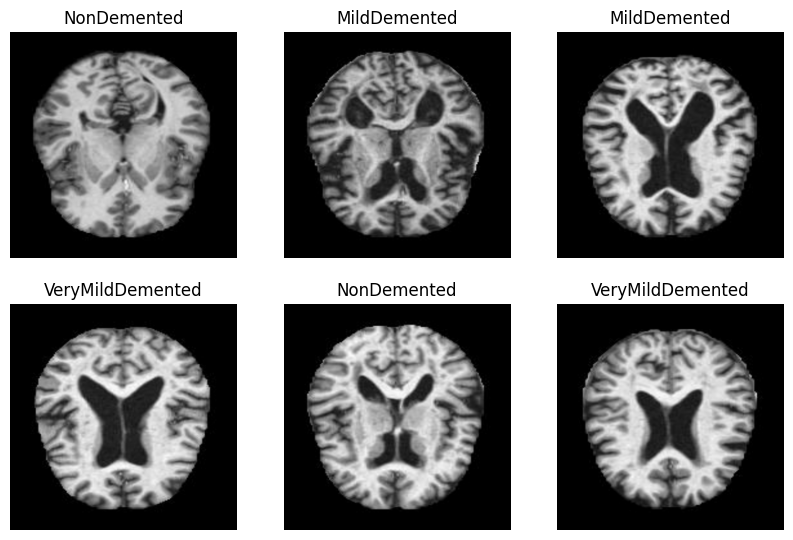

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_data.class_names[labels[i]])
        plt.axis("off")

In [ ]:
train_batch_size = 10
val_batch_size = 5
test_batch_size = 5

hparams = {'train_data': train_data,
           'val_data': val_data,
           'test_data': test_data,
           'train_batch_size': train_batch_size,
           'val_batch_size': val_batch_size,
           'test_batch_size': test_batch_size,
           'num_workers': 20,
           'train_shuffle': True,
           'val_shuffle': False,
           'test_shuffle': False,
           'train_drop_last': False,
           'val_drop_last': False,
           'test_drop_last': False,
          }
batch = next(iter(train_data))
print(batch[0].shape)
print(batch[1].shape)

(32, 384, 384, 3)
(32,)


Model Development

In [ ]:
import torch
import torch.nn as nn
from vit_pytorch import ViT

In [ ]:
pretrained = True
vit_config = ViTConfig(image_size=image_size,
                       patch_size=32,
                       num_labels=3,
                       output_attentions=True,
                       hidden_dropout_prob=0.1,
                       # attention_probs_dropout_prob=0.1,
                      )

In [ ]:
import torch
import torch.nn as nn
import timm

class ViTModel(nn.Module):
    def __init__(self, num_classes):
        super(ViTModel, self).__init__()
        self.transformer = timm.create_model('vit_base_patch32_384', pretrained=True)
        self.transformer.head = nn.Linear(self.transformer.head.in_features, num_classes)

    def forward(self, x):
        x = self.transformer(x)
        return x

# Create an instance of the ViTModel
model = ViTModel(num_classes=4)

# Print the model architecture
print(model)


ViTModel(
  (transformer): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate='none

In [ ]:
import torch
import torch.nn as nn
from vit_pytorch import ViT

# Define the Vision Transformer model
class ViTModel(nn.Module):
    def __init__(self, num_classes):
        super(ViTModel, self).__init__()
        self.transformer = ViT(
            image_size=384,
            patch_size=32,
            num_classes=num_classes,
            dim=768,
            depth=12,
            heads=8,
            mlp_dim=3072,
            dropout=0.1,
            emb_dropout=0.1
        )

    def forward(self, x):
        x = self.transformer(x)
        return x

# Create an instance of the ViTModel
model = ViTModel(num_classes=4)

# Print the model architecture
print(model)



ViTModel(
  (transformer): ViT(
    (to_patch_embedding): Sequential(
      (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=32, p2=32)
      (1): LayerNorm((3072,), eps=1e-05, elementwise_affine=True)
      (2): Linear(in_features=3072, out_features=768, bias=True)
      (3): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    )
    (dropout): Dropout(p=0.1, inplace=False)
    (transformer): Transformer(
      (layers): ModuleList(
        (0-11): 12 x ModuleList(
          (0): PreNorm(
            (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (fn): Attention(
              (attend): Softmax(dim=-1)
              (dropout): Dropout(p=0.1, inplace=False)
              (to_qkv): Linear(in_features=768, out_features=1536, bias=False)
              (to_out): Sequential(
                (0): Linear(in_features=512, out_features=768, bias=True)
                (1): Dropout(p=0.1, inplace=False)
              )
            )
          )
         

In [ ]:
print(model)

ViTModel(
  (transformer): ViT(
    (to_patch_embedding): Sequential(
      (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=32, p2=32)
      (1): LayerNorm((3072,), eps=1e-05, elementwise_affine=True)
      (2): Linear(in_features=3072, out_features=768, bias=True)
      (3): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    )
    (dropout): Dropout(p=0.1, inplace=False)
    (transformer): Transformer(
      (layers): ModuleList(
        (0-11): 12 x ModuleList(
          (0): PreNorm(
            (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (fn): Attention(
              (attend): Softmax(dim=-1)
              (dropout): Dropout(p=0.1, inplace=False)
              (to_qkv): Linear(in_features=768, out_features=1536, bias=False)
              (to_out): Sequential(
                (0): Linear(in_features=512, out_features=768, bias=True)
                (1): Dropout(p=0.1, inplace=False)
              )
            )
          )
         

In [ ]:
!pip install --upgrade pycuda
!pip install --upgrade pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached pytorch-1.0.2.tar.gz (689 bytes)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pytorch
  Running setup.py clean for pytorch
Failed to build pytorch
ERROR: Could not build wheels for pytorch, which is required to install pyproject.toml-based projects


In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
# Selecting GPU
GPU = {0: torch.device('cuda:0'),
       1: torch.device('cuda:1'),
       2: torch.device('cuda' if torch.cuda.is_available() else 'cpu')
      }

## Single-GPU trining
device = GPU[1]


In [ ]:
import accuracy as acc

In [ ]:
## Multi-GPU training
# device = GPU[2]
# model = ViT(num_labels=3, pretrained=pretrained)
# model= nn.DataParallel(model)
# model.to(device);

if pretrained:
    feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch32-384',
                                                            do_resize=False,
                                                            do_normalize=False)
else:
    feature_extractor = ViTImageProcessor(do_resize=False,
                                            size=image_size,
                                            do_normalize=False)


optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=0.15)

class_0_freq = 140
class_1_freq = 160
class_2_freq = 160
class_3_freq = 180
weight = torch.tensor([1/class_0_freq, 1/class_1_freq, 1/class_2_freq]).to(device)
criterion = nn.CrossEntropyLoss()
writer = SummaryWriter()
scheduler = ExponentialLR(optimizer, gamma=0.999)

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:
epochs = 100
train_accs = []
valid_accs = []
train_losses = []
valid_losses = []
best_loss = 100
best_acc = 0
saved = False
patience = 0
early_stop = 10

In [ ]:
for epoch in range(epochs):
    print(Fore.YELLOW + f"Epoch: {(epoch+1):02}/{epochs}")
    for step, (x, y) in enumerate(train_data):

        criterion.weight = weight


        optimizer.zero_grad()

        optimizer.step()



Epoch: 01/100
Epoch: 02/100
Epoch: 03/100
Epoch: 04/100
Epoch: 05/100
Epoch: 06/100
Epoch: 07/100
Epoch: 08/100
Epoch: 09/100
Epoch: 10/100
Epoch: 11/100
Epoch: 12/100
Epoch: 13/100
Epoch: 14/100
Epoch: 15/100
Epoch: 16/100
Epoch: 17/100
Epoch: 18/100
Epoch: 19/100
Epoch: 20/100
Epoch: 21/100
Epoch: 22/100
Epoch: 23/100
Epoch: 24/100
Epoch: 25/100
Epoch: 26/100
Epoch: 27/100
Epoch: 28/100
Epoch: 29/100
Epoch: 30/100
Epoch: 31/100
Epoch: 32/100
Epoch: 33/100
Epoch: 34/100
Epoch: 35/100
Epoch: 36/100
Epoch: 37/100
Epoch: 38/100
Epoch: 39/100
Epoch: 40/100
Epoch: 41/100
Epoch: 42/100
Epoch: 43/100
Epoch: 44/100
Epoch: 45/100
Epoch: 46/100
Epoch: 47/100
Epoch: 48/100
Epoch: 49/100
Epoch: 50/100
Epoch: 51/100
Epoch: 52/100
Epoch: 53/100
Epoch: 54/100
Epoch: 55/100
Epoch: 56/100
Epoch: 57/100
Epoch: 58/100
Epoch: 59/100
Epoch: 60/100
Epoch: 61/100
Epoch: 62/100
Epoch: 63/100
Epoch: 64/100
Epoch: 65/100
Epoch: 66/100
Epoch: 67/100
Epoch: 68/100
Epoch: 69/100
Epoch: 70/100
Epoch: 71/100
Epoch:

In [ ]:
pip install classifier

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 2.3 MB/s eta 0:00:00
  Created wheel for classifier: filename=classifier-2.0-py3-none-any.whl size=5030 sha256=d312ad5dc0b99505f379dd4c4ee93d7856672625eba137c1ba2af31090e56610
  Stored in directory: /root/.cache/pip/wheels/c4/e9/f7/a0f40cc27242c7c8ef198c37bc0461f7ac90102cdbb0df7999
Successfully built classifier


In [ ]:
if (step % 10 == 0) or (step == len(train_data)):
            train_loss = sum(train_losses)/len(train_losses)
            train_acc = sum(train_accs)/len(train_accs)
            writer.add_scalar('train_loss', train_loss, epoch * len(train_dataloader) + step)
            writer.add_scalar('train_acc', train_acc, epoch * len(train_dataloader) + step)
            train_losses.clear()
            train_accs.clear()


In [ ]:
  model.eval()

ViTModel(
  (transformer): ViT(
    (to_patch_embedding): Sequential(
      (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=32, p2=32)
      (1): LayerNorm((3072,), eps=1e-05, elementwise_affine=True)
      (2): Linear(in_features=3072, out_features=768, bias=True)
      (3): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    )
    (dropout): Dropout(p=0.1, inplace=False)
    (transformer): Transformer(
      (layers): ModuleList(
        (0-11): 12 x ModuleList(
          (0): PreNorm(
            (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (fn): Attention(
              (attend): Softmax(dim=-1)
              (dropout): Dropout(p=0.1, inplace=False)
              (to_qkv): Linear(in_features=768, out_features=1536, bias=False)
              (to_out): Sequential(
                (0): Linear(in_features=512, out_features=768, bias=True)
                (1): Dropout(p=0.1, inplace=False)
              )
            )
          )
         

In [ ]:
model.train

<bound method Module.train of ViTModel(
  (transformer): ViT(
    (to_patch_embedding): Sequential(
      (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=32, p2=32)
      (1): LayerNorm((3072,), eps=1e-05, elementwise_affine=True)
      (2): Linear(in_features=3072, out_features=768, bias=True)
      (3): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    )
    (dropout): Dropout(p=0.1, inplace=False)
    (transformer): Transformer(
      (layers): ModuleList(
        (0-11): 12 x ModuleList(
          (0): PreNorm(
            (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (fn): Attention(
              (attend): Softmax(dim=-1)
              (dropout): Dropout(p=0.1, inplace=False)
              (to_qkv): Linear(in_features=768, out_features=1536, bias=False)
              (to_out): Sequential(
                (0): Linear(in_features=512, out_features=768, bias=True)
                (1): Dropout(p=0.1, inplace=False)
              )
     

In [ ]:
 scheduler.step()

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


In [ ]:
!pip install --upgrade pycuda



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install --upgrade pytorch


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached pytorch-1.0.2.tar.gz (689 bytes)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pytorch
  Running setup.py clean for pytorch
Failed to build pytorch
ERROR: Could not build wheels for pytorch, which is required to install pyproject.toml-based projects


In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cpu
